# Locally Connected Neural Network

Our Final Project


In [1]:
#Use the setup that were given in assignment2/ConolutionNetworks
import numpy as np
import matplotlib.pyplot as plt
from cs682.classifiers.cnn import *
from cs682.data_utils import get_CIFAR10_data
from cs682.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs682.layers import *
from cs682.fast_layers import *
from cs682.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


In [3]:
#Import the layer and net work we implimented
from lcn import *
from lc_fc_net import *

# Locally Connected Neural Network: Naive forward pass

In [7]:
x_shape = (2, 3, 5, 5)
w_shape = (2, 75, 2, 2)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)


lcn_param = {'center_dist': 1}
out, _ = lcn_forward(x, w, b, lcn_param)

print(out.shape)


(2, 2, 2, 2)


In [12]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 75, 2, 2)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 2, 2)
lcn_param = {'center_dist': 1}

dx_num = eval_numerical_gradient_array(lambda x: lcn_forward(x, w, b, lcn_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: lcn_forward(x, w, b, lcn_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: lcn_forward(x, w, b, lcn_param)[0], b, dout)

out, cache = lcn_forward(x, w, b, lcn_param)
dx, dw, db = lcn_backward(dout, cache)

# Your errors should be around e-8 or less.
print('Testing lcn_backward function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing lcn_backward function
dx error:  1.6484967521315567e-08
dw error:  1.5481685674904215e-07
db error:  3.70166051916638e-11


# Speed test

In [15]:
# Compare the time with conv_naive
from time import time
np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
w_conv = np.random.randn(32, 3, 5, 5)
w_lcn = np.random.randn(2, 3072, 5, 5)
b_conv = np.random.randn(32,)
b_lcn = np.random.randn(2,)
dout_conv = np.random.randn(100, 32, 32, 32)
dout_lcn = np.random.randn(100, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 2}
lcn_param = {'center_dist': 1}


t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w_conv, b_conv, conv_param)
t1 = time()
out_lcn, cache_lcn = lcn_forward(x, w_lcn, b_lcn, lcn_param)
t2 = time()

print('Testing lcn_forward:')
print('Conv: %fs' % (t1 - t0))
print('LCN: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout_conv, cache_naive)
t1 = time()
dx_lcn, dw_lcn, db_lcn = lcn_backward(dout_lcn, cache_lcn)
t2 = time()

print('Testing lcn_backward:')
print('Conv: %fs' % (t1 - t0))
print('LCN: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))

Testing lcn_forward:
Conv: 23.501356s
LCN: 0.269162s
Speedup: 87.313073x
Testing lcn_backward:
Conv: 35.468672s
LCN: 0.371476s
Speedup: 95.480403x


In [16]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerLCNNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
t0 = time()
solver.train()
t1 = time()
print('ThreeLayerLCNNet: %fs' % (t1 - t0))

(Iteration 1 / 30) loss: 2.303085
(Epoch 0 / 15) train acc: 0.190000; val_acc: 0.114000
(Iteration 2 / 30) loss: 2.297378
(Epoch 1 / 15) train acc: 0.160000; val_acc: 0.117000
(Iteration 3 / 30) loss: 2.291885
(Iteration 4 / 30) loss: 2.278358
(Epoch 2 / 15) train acc: 0.210000; val_acc: 0.127000
(Iteration 5 / 30) loss: 2.272711
(Iteration 6 / 30) loss: 2.249300
(Epoch 3 / 15) train acc: 0.190000; val_acc: 0.138000
(Iteration 7 / 30) loss: 2.240283
(Iteration 8 / 30) loss: 2.211211
(Epoch 4 / 15) train acc: 0.190000; val_acc: 0.137000
(Iteration 9 / 30) loss: 2.190593
(Iteration 10 / 30) loss: 2.079509
(Epoch 5 / 15) train acc: 0.190000; val_acc: 0.138000
(Iteration 11 / 30) loss: 2.119107
(Iteration 12 / 30) loss: 2.151853
(Epoch 6 / 15) train acc: 0.190000; val_acc: 0.138000
(Iteration 13 / 30) loss: 2.070984
(Iteration 14 / 30) loss: 2.026814
(Epoch 7 / 15) train acc: 0.210000; val_acc: 0.143000
(Iteration 15 / 30) loss: 2.065783
(Iteration 16 / 30) loss: 1.929231
(Epoch 8 / 15) tr

In [17]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerLCNNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=30, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
t0 = time()
solver.train()
t1 = time()
print('ThreeLayerLCNNet: %fs' % (t1 - t0))

(Iteration 1 / 60) loss: 2.303085
(Epoch 0 / 30) train acc: 0.190000; val_acc: 0.114000
(Iteration 2 / 60) loss: 2.297378
(Epoch 1 / 30) train acc: 0.160000; val_acc: 0.117000
(Iteration 3 / 60) loss: 2.291885
(Iteration 4 / 60) loss: 2.278358
(Epoch 2 / 30) train acc: 0.210000; val_acc: 0.127000
(Iteration 5 / 60) loss: 2.272711
(Iteration 6 / 60) loss: 2.249300
(Epoch 3 / 30) train acc: 0.190000; val_acc: 0.138000
(Iteration 7 / 60) loss: 2.240283
(Iteration 8 / 60) loss: 2.211211
(Epoch 4 / 30) train acc: 0.190000; val_acc: 0.137000
(Iteration 9 / 60) loss: 2.190593
(Iteration 10 / 60) loss: 2.079509
(Epoch 5 / 30) train acc: 0.190000; val_acc: 0.138000
(Iteration 11 / 60) loss: 2.119107
(Iteration 12 / 60) loss: 2.151853
(Epoch 6 / 30) train acc: 0.190000; val_acc: 0.138000
(Iteration 13 / 60) loss: 2.070984
(Iteration 14 / 60) loss: 2.026814
(Epoch 7 / 30) train acc: 0.210000; val_acc: 0.143000
(Iteration 15 / 60) loss: 2.065783
(Iteration 16 / 60) loss: 1.929231
(Epoch 8 / 30) tr

## Plot
Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

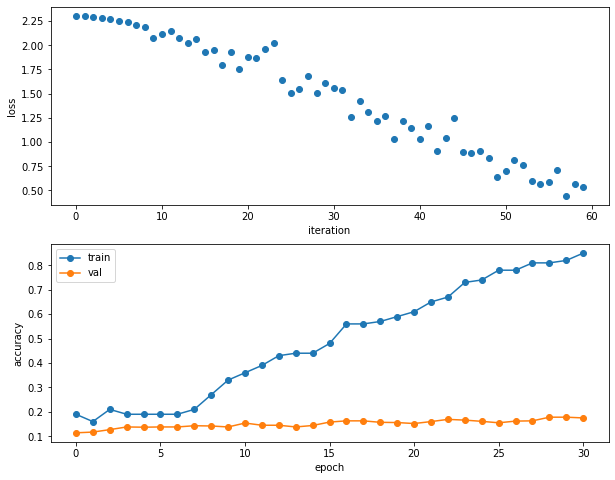

In [18]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net


In [19]:
model = ThreeLayerLCNNet(weight_scale=1e-2, hidden_dim=500, reg=1e-3)

solver = Solver(model, data,
                num_epochs=2, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
t0 = time()
solver.train()
t1 = time()
print('ThreeLayerLCNNet train: %fs' % (t1 - t0))

(Iteration 1 / 1960) loss: 2.313389
(Epoch 0 / 2) train acc: 0.128000; val_acc: 0.139000
(Iteration 21 / 1960) loss: 2.145889
(Iteration 41 / 1960) loss: 2.195151
(Iteration 61 / 1960) loss: 1.873622
(Iteration 81 / 1960) loss: 1.957064
(Iteration 101 / 1960) loss: 1.873685
(Iteration 121 / 1960) loss: 1.847917
(Iteration 141 / 1960) loss: 1.871845
(Iteration 161 / 1960) loss: 1.875362
(Iteration 181 / 1960) loss: 1.719671
(Iteration 201 / 1960) loss: 1.985056
(Iteration 221 / 1960) loss: 2.032706
(Iteration 241 / 1960) loss: 1.628344
(Iteration 261 / 1960) loss: 1.832034
(Iteration 281 / 1960) loss: 1.800867
(Iteration 301 / 1960) loss: 1.876811
(Iteration 321 / 1960) loss: 1.846718
(Iteration 341 / 1960) loss: 1.939476
(Iteration 361 / 1960) loss: 1.533312
(Iteration 381 / 1960) loss: 2.018805
(Iteration 401 / 1960) loss: 1.696750
(Iteration 421 / 1960) loss: 1.581908
(Iteration 441 / 1960) loss: 1.625276
(Iteration 461 / 1960) loss: 1.489770
(Iteration 481 / 1960) loss: 1.592526
(It

In [32]:
# Visualize the learned weights for each class
w = model.params['W1'].transpose(0, 2, 3, 1)
w = w.reshape(50, 32, 32, 3)

w_min, w_max = np.min(w), np.max(w)

for i in range(50):
    plt.subplot(10, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[i, :, :, :] - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.gcf().set_size_inches(100, 100)
    plt.axis('off')

TypeError: subplot() takes 1 or 3 positional arguments but 4 were given

<Figure size 720x576 with 0 Axes>